# Basics of parallel and distributed computing with DASK

## Recap on task parallelization (this time using Dask)

We should now start to feel quite familiar with the programming pattern already discussed in the previous lectures when we discussed Hadood MapReduce and the Spark framework.

Asides from the details of the API, which depend on the framework implementation, and from the inner structure of the job scheduling and resorce manager, most of the distributed computing frameworks offer us a way of parallelizing our jobs by means of Graph schedulers and Task optimizers.

The goal is always the same, no matter the tool used to reach it:
- store large datasets which won't fit into memory in a set of partitions 
- first plan the entire data processing, then optimize it to break it into smaller tasks
- finally, distribute the processing close to the data, instead of moving the data (data-locality)

In Dask, we still have access to a set of dataset representations:
- Dask bag (~ equivalent to the Spark RDD)
- Dask array
- Dask dataframe (~ equivalent to the Spark DataFrame)

However, Dask is mainly a scheduler (this time written in Python and not in Scala as Spark \[*\]), which allows lazy execution of python-like code for distributing it across a multitude of workers.


\[*\] To be clear, the fact that the scheduler is in Python does not mean it's _better_ than Spark for our purposes.  Python and Scala/Java are different in a multitude of ways, and both have pros and cons. For instance, as of today, it is known that due to the way Python handles and manages memory during the execution of an application, Dask still suffers from a issues with so-called unmanaged memory throughout the life of an application (see for instance the [link](https://coiled.io/blog/tackling-unmanaged-memory-with-dask/)).

## Starting a cluster and first lazy computation with `delayed`

We can use Dask locally, to exploit the multi-tasking/processing functionalities, or setup a cluster and deploy a scheduler and a number of worker nodes.

After we setup a cluster, we initialize a Client by pointing it to the address of a Scheduler.

In [1]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

In [2]:
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_cluster


In [3]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 2GB --nworkers 2 &

fi

In [4]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

In [5]:
from dask.distributed import Client

if CLUSTER_TYPE == 'local':
    
    client = Client()

elif CLUSTER_TYPE == 'docker_container':
    
    client = Client('{}:8786'.format(host_ip))
    
elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    client = Client('dask-scheduler:8786')
    
client

<Client: 'tcp://172.25.0.2:8786' processes=4 threads=4, memory=1.91 GiB>

We can check the status of the cluster at the `localhost:8787` dashboard, where we have an overview of both the status of the workers, and the execution of the DAG task graphs, when we'll start using them.

The simplest example to parallelize any arbitrary Python code in Dask can be presented by running a couple of simple arbitrary operarions, described here with 2 functions and an arbitrary sleep time of 1 second.
The sleep time is meant to represent an arbitrariliy complex code, and the time required for its execution.

In [7]:
from time import sleep

def increment(x):
    # sleep for 1s
    sleep(1)
    
    # given the input x, return x+1
    return x + 1

def decrement(x):
    # sleep for 1s
    sleep(1)

    # given the input x, return x-1
    return x - 1


def add(x, y):
    # sleep for 1s
    sleep(1)
    
    # given the inputs x and y, return x+y
    return x + y

We can test the functions locally by running them on the client (not on the cluster).

In [8]:
%%time

x = increment(1)
y = decrement(2)
z = add(x, y)

CPU times: user 8.92 ms, sys: 159 µs, total: 9.08 ms
Wall time: 3 s


In order to let Dask take advantage of the processing units assigned to the cluster, we have to let it elaborate the DAG corresponding to the execution of the code we want to deploy on the cluster, and then let the scheduler dispatch the tasks to the workers.

This is done in Dask by declaring that a function is `delayed`.

The `delayed` Dask method takes several arguments. 
The first argument is the function that has to be executed in parallel.
The following arguments are the arguments of the original function.

We now want to transform the `inc` and `add` functions, therefore making them `lazy`.

In [9]:
from dask import delayed

In [10]:
%%time

x = delayed(increment)(1)
y = delayed(decrement)(2)
z = delayed(add)(x, y)

CPU times: user 4.89 ms, sys: 1.54 ms, total: 6.42 ms
Wall time: 5.11 ms


At this stage, as usual with lazy operations, we don't have the results stored in `z`.

`z` at this stage is just the "plan" of the code execution, made by the DAG task scheduler.

We can visualize the plan of the execution with the `visualize()` method.

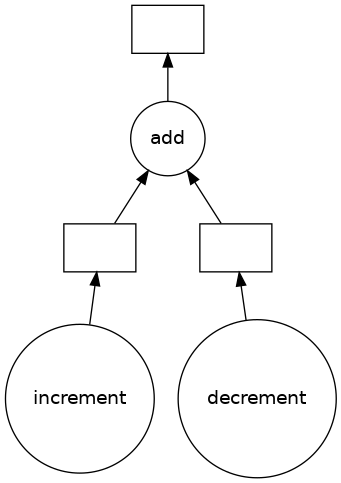

In [11]:
z.visualize()

In order to actually execture the job, we have to ask Dask to return the results of the lazy operation with the `compute()` method.

Under the carpet, Dask will ship the computational graph to the scheduler, and will dispatch the tasks to the workers, similarly to what already discussed for Spark

In [12]:
%%time

z.compute() 

CPU times: user 441 ms, sys: 41.4 ms, total: 483 ms
Wall time: 2.59 s


3

## Futures and Eager computation with `submit`

The eager operation alternative to `delayed` in Dask is the `submit`, which instruct Dask to start executing our task on the cluster right away.

In [13]:
future = client.submit(increment, 1)

The function `increment` with its agurment `1` is submitted to the cluster, and the `future` object is returned right away. 

The `submit` operation has in fact returned a so-called execution *promise* (the `future` variable) of the instruction that we have submitted.
It doesn't necessarily mean that the execution has been completed, as the cluster might take some time to execute it.

The `future` variable in fact **doen not contains the result**, but just the promise of it, when the elaboration will be completed. 
The result of the computation will be left on the worker nodes of our cluster, and will not be sent back to our client until we reclaim it.

To retrieve the result we do invoke the `gather` function (similarly to the collect in Spark).

In [14]:
future

<Future: pending, key: increment-81964c0fd49f3e72581ad2cb6fc3d0b5>

In [15]:
client.gather(future)

2

This approach can be extremely useful in situations where we need to submit an instruction multiple times, perhaps with different input parameters. 
This is a for instance a quite frequent scenario in in machine learning, for example when we need to optmize an algorithm for a particular dataset over the hyper-parameter space. 

The idea of this approach allows us to `map` the instruction that we want to executo to each argument of a dataset, thus submitting the same operation on the entire dataset.

In [16]:
data = [0, 1, 2, 3, 4, 5, 6, 7, 8]

future_results = client.map(increment, data)
future_results

[<Future: pending, key: increment-a0e5b624ef2e67717d01f319b8b0f586>,
 <Future: finished, type: int, key: increment-81964c0fd49f3e72581ad2cb6fc3d0b5>,
 <Future: pending, key: increment-2c128f2898f726f157daf13aa7ffe270>,
 <Future: pending, key: increment-0da17948906e3b48166e4475c2db2c48>,
 <Future: pending, key: increment-05d934f273f81ee2b50143b89dd9f22f>,
 <Future: pending, key: increment-86b8de3a7671424063705faab9e0565e>,
 <Future: pending, key: increment-b20b33ff7cf2bcb4cbd38db2b3e1966e>,
 <Future: pending, key: increment-757c4e48965edd1d57024d5c211aaf86>,
 <Future: pending, key: increment-f5d36353e202d4d3e2d3987d35bc8b76>]

In [18]:
new_data = client.gather(future_results)
print(new_data)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


If we need to wait for the result of a `submit` computation to be ready (say we need it as an input in other computations), we may still ask Python to block the execution of the new code and `wait` the computation of the future. 

In [19]:
from dask.distributed import wait

new_future = client.map(increment, new_data)
wait(new_future)

DoneAndNotDoneFutures(done={<Future: finished, type: int, key: increment-757c4e48965edd1d57024d5c211aaf86>, <Future: finished, type: int, key: increment-81964c0fd49f3e72581ad2cb6fc3d0b5>, <Future: finished, type: int, key: increment-86b8de3a7671424063705faab9e0565e>, <Future: finished, type: int, key: increment-05d934f273f81ee2b50143b89dd9f22f>, <Future: finished, type: int, key: increment-f5d36353e202d4d3e2d3987d35bc8b76>, <Future: finished, type: int, key: increment-2c128f2898f726f157daf13aa7ffe270>, <Future: finished, type: int, key: increment-0da17948906e3b48166e4475c2db2c48>, <Future: finished, type: int, key: increment-bc2376c192a73ade6b7243a1621630d4>, <Future: finished, type: int, key: increment-b20b33ff7cf2bcb4cbd38db2b3e1966e>}, not_done=set())

In [20]:
client.gather(new_future)

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In complete analogy to what we have discussed with the `delayed` lazy execution, we can combine multiple instruction that have to be submitted to the cluster and create a more complex job to run on our cluster.

We should remember that the results of the `submit` execution reside on the cluster until a `gather` is used.

This means that we can submit to the cluster a task that takes as argument an execution promise of an instruction that has been previosly submitted. 

The `gather` function can thus be invoked at the end of the program, invoked only when the results have to be effectively retrived from the cluster.

In [21]:
x = client.submit(increment, 1)
y = client.submit(decrement, 2)
total = client.submit(add, x, y)

In [22]:
print(total)          # This is still the execution promise

<Future: pending, key: add-76651dee52d254431774fa4c190ae75d>


In [23]:
client.gather(total)  # This is the final result

3

### Exercise: Parallelization of a for loop

At this point, with the previous knowledge of what discussed with Spark, and the `delayed` and `compute` Dask operations, we should already be able to run simple "dummy" tasks.

Starting from a list $\vec{x}$ of numbers:
1. increment each element $x_i$ by a random value $\delta x_i$ (in the 0-1 range)
2. multiply the resulting value by 10
3. sum all resulting values

In [24]:
import time

data = [1, 2, 3, 4, 5, 6, 7, 8]

import random

# increment function
def add_rand(x):
    return x+random.random()

# multiplication function
def mult_ten(x):
    return x*10

start = time.time()

results = []

for x in data:
    y =  delayed(add_rand)(x) # put your code here.
    z =  delayed(mult_ten)(y) # put your code here.
    results.append(z)
    
total = delayed(sum)(results) #put your code here. 

end = time.time()

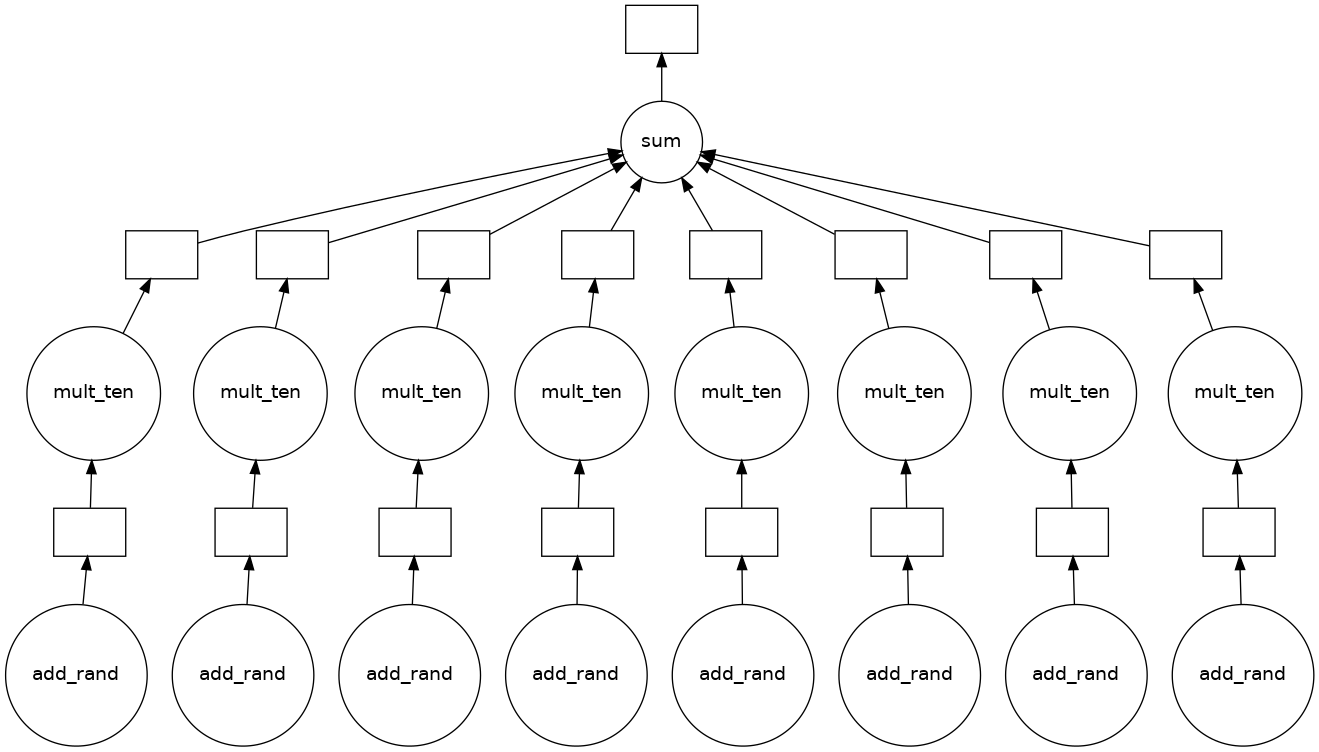

In [25]:
total.visualize()

In [26]:
%%time
result = total.compute()

CPU times: user 61.6 ms, sys: 11.2 ms, total: 72.8 ms
Wall time: 268 ms


In [27]:
print("result: ",result)

result:  391.66205115230593


Run the same task with the eager `submit` execution

In [28]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

results = []

for x in data:
    y =  client.submit(add_rand, x) # put your code here.
    z =  client.submit(mult_ten, y) # put your code here.
    results.append(z)
    
total = client.submit(sum,results) #put your code here. 

In [29]:
total

<Future: finished, type: float, key: sum-0fa96d87a6a4edb6e0cc313ca7cc8f3f>

In [30]:
print("result: ",result)

result:  391.66205115230593


There is clearly another alternative to the previous approach:

In [31]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

y =  client.map(add_rand, data) # put your code here.
z =  client.map(mult_ten, y) # put your code here.
    
total = client.submit(sum,z) #put your code here. 

In [32]:
total

<Future: finished, type: float, key: sum-0fa96d87a6a4edb6e0cc313ca7cc8f3f>

In [33]:
print("result: ",result)

result:  391.66205115230593


### Exercise: Sum reduction on a tree

So far we acted mostly with _map_ like operations, and we collected all outputs in a single `sum` operation.

We might want to briefly explore how we could write in Dask an equivalent _reduce_ function to evaluate the sum of a list of elements pair-wise

Here there is a schema on wath we have to do:

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

Here there is the usual pair-reduction algorithm with nested for loop and a bit of simple Python logic.

In [34]:
L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

start = time.time()
while len(L) > 1:
    _ = []
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            pair_sum = add(L[i], L[i + 1])  # add neighbor
        else:
            pair_sum = add(L[i], 0)         # add 0
        _.append(pair_sum)
    L = _ 
    
print("result:",L[0])
end = time.time()

print("Computation took {:.2f}s".format(end-start))

result: 45
Computation took 11.01s


To parallelize this reduce task, we define as `delayed` the pair-wise sum of neighbour elements.

In [35]:
L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

while len(L) > 1:
    _ = []
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            pair_sum = delayed(add)(L[i], L[i + 1])  # add neighbor
        else:
            pair_sum = delayed(add)(L[i], 0)         # add 0
        _.append(pair_sum)
    L = _ 

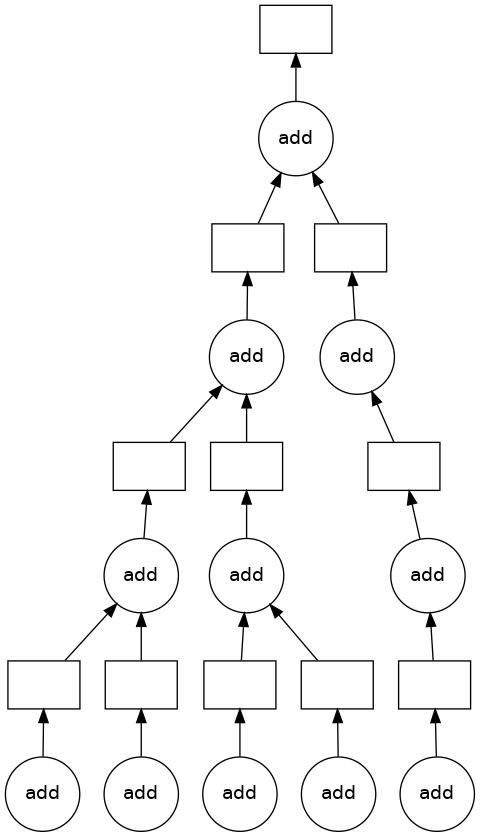

In [36]:
L[0].visualize()

In [37]:
%%time 
result = L[0].compute()

CPU times: user 70.9 ms, sys: 8.03 ms, total: 78.9 ms
Wall time: 5.17 s


In [38]:
print("result",result)

result 45


### Exercise: Count how many words are present in a series of documents 

Starting from a dataset of pieces of text taken from `sklearn` we would like to count how many words are present in each document and calculate how many words are in the total dataset. 

The documents are ~8000.

In [39]:
from sklearn.datasets import fetch_20newsgroups
from dask.distributed import Client
import time

categories = [
     'comp.graphics',
     'comp.os.ms-windows.misc',
     'comp.sys.ibm.pc.hardware',
     'comp.sys.mac.hardware',
     'comp.windows.x',
     'misc.forsale',
     'rec.autos',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.crypt',
     'sci.electronics',
     'sci.med',
     'sci.space'
]

dataset = fetch_20newsgroups(subset='train', categories=categories ).data

In [40]:
print("Documents in the dataset:",len(dataset))

Documents in the dataset: 8283


In [41]:
def count_words_in_document(text):
    splitted_words = text.split()
    return len(splitted_words)

The single-threaded execution in Python can be run by the following

In [44]:
%%time

total_words_in_all_data = 0
total_words_in_document = []

for index in range(len(dataset)):
    total_words_in_document.append(count_words_in_document(dataset[index]))
    total_words_in_all_data += total_words_in_document[-1]

CPU times: user 663 ms, sys: 4.19 ms, total: 667 ms
Wall time: 666 ms


In [45]:
print("Total number of words in the dataset: {}".format(total_words_in_all_data))

Total number of words in the dataset: 2038444


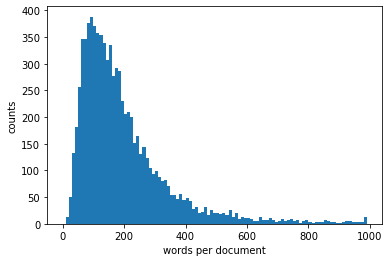

In [46]:
import matplotlib.pyplot as plt

plt.hist(total_words_in_document,bins=range(0,1000,10));
plt.xlabel('words per document');
plt.ylabel('counts');

Distributed version with `delayed` lazy execution:

In [47]:
%%time

total_words_in_all_data = 0
total_words_in_document = []

for index in range(len(dataset)):
    total_words_in_document.append(delayed(count_words_in_document)(dataset[index]))

total_words_in_all_data = delayed(sum)(total_words_in_document)

CPU times: user 2.84 s, sys: 203 ms, total: 3.04 s
Wall time: 2.86 s


In [48]:
result = total_words_in_all_data.compute()
print("Total number of words in the dataset: {}".format(result))

Total number of words in the dataset: 2038444


Distributed version using `map` and `submit`:

In [49]:
%%time

total_words_in_document = client.map(count_words_in_document, dataset)
total_words_in_all_data = client.submit(sum, total_words_in_document)

CPU times: user 2.45 s, sys: 18.4 ms, total: 2.47 s
Wall time: 2.47 s


In [50]:
result = client.gather(total_words_in_all_data)
print("Total number of words in the dataset: {}".format(result))

Total number of words in the dataset: 2038444


Note how distrbuting the calculation this time was way slower due to the fact that we have to move data accross all nodes.

### Exercise: Calculate the first $n$ Fibonacci numbers

Let's define the algorithm to evaluate the sequence of Fibonacci up to the $n$-th element:

1,1,3,5,8,13,...

In [51]:
def fibonacci_sequential(num):
    i = 1
    if num <= 0:
        fibonacci = []
    elif num == 1:
        fibonacci = []
        fibonacci.append(1)
    elif num == 2:
        fibonacci = []
        fibonacci.append(1)
        fibonacci.append(1)
    elif num > 2:
        fibonacci = []
        fibonacci.append(1)
        fibonacci.append(1)
        while i < (num - 1):
            fibonacci.append(fibonacci[i] + fibonacci[i-1])
            i += 1
    return fibonacci

result = fibonacci_sequential(8)
print("The first n fibonacci numbers are: " + str(result))

The first n fibonacci numbers are: [1, 1, 2, 3, 5, 8, 13, 21]


Let's implement the same algorithm using the Dask lazy evaluation, with `delayed`, and inspect the task graph

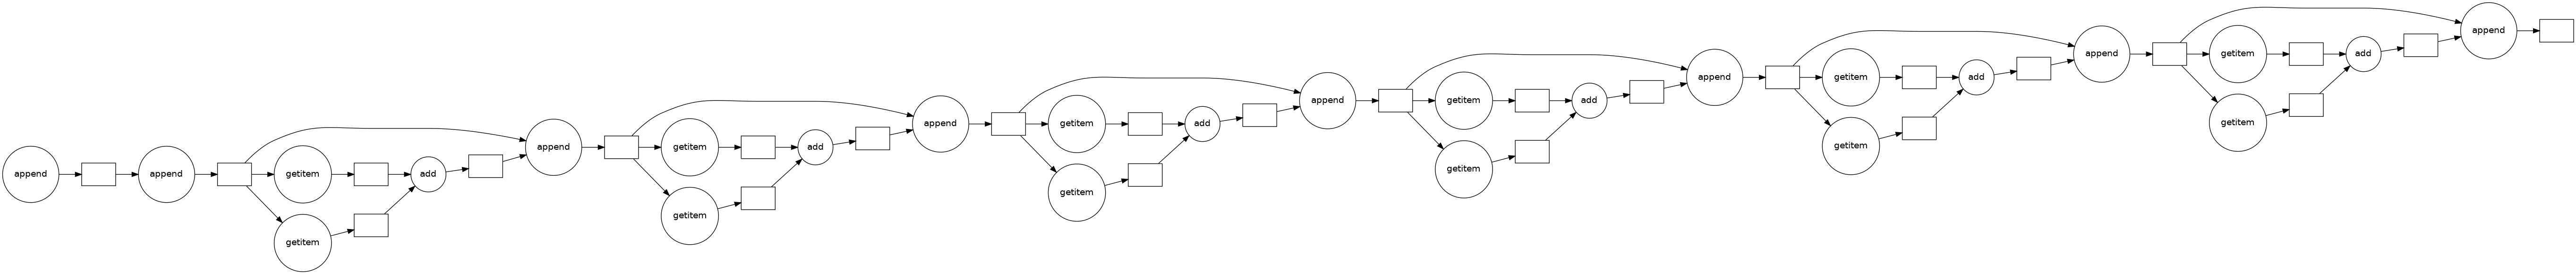

In [52]:
# # in order to generalize the append
def append(arr = [], val = 0):
    if val != None:
        arr.append(val)
    return arr

def fibonacci(num):
    i = 1
    if num == 0:
        new_val = delayed(append)([], None)
    elif num == 1:
        new_val = delayed(append)([], 1)
    elif num == 2:
        val_one = delayed(append)([], 1)
        new_val = delayed(append)(val_one, 1)
    elif num > 2:
        val_one = delayed(append)([], 1)
        new_val = delayed(append)(val_one, 1)
        while i < (num - 1):
            new_val = delayed(append)(new_val, new_val[i] + new_val[i-1])
            i += 1
    return new_val
result = fibonacci(8)
result.visualize(rankdir="LR")

In [53]:
result.compute()

[1, 1, 2, 3, 5, 8, 13, 21]

### Exercise: Monte Carlo Integration

Let's assume we want to integrate of a function via MonteCarlo technique, as you have discussed in LCP Module A.

Let's use the function $$f(x) =\sin^2{\frac{1}{x(2-x)}}$$ and let's integrate in the range $(0,2)$

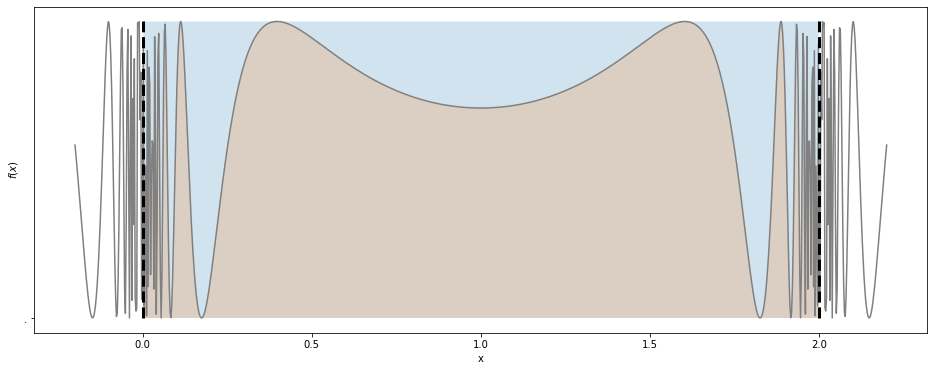

In [54]:
import numpy as np

def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(-0.2,2.2,1000)

plt.figure(figsize=(16,6));
plt.plot(x,f(x),'grey','.');
plt.fill_between(x[np.where((x>0) & (x<2))],[1]*len(np.where((x>0) & (x<2))), alpha=0.2);
plt.fill_between(x[np.where((x>0) & (x<2))],f(x[np.where((x>0) & (x<2))]), alpha=0.2);
plt.vlines([0, 2], 0, 1, colors = ["k", "k"], linestyles = ["dashed", "dashed"],linewidths=[3,3],zorder=20);
plt.xlabel('x');
plt.ylabel('$f(x)$');

Create the single-thread Python code to execute this task, and evaluate the integral over N=100 000 points

In [55]:
%%time
# Monte Carlo integration
N=100000
count=[]
def pass_function():
    x=2*np.random.random()
    y=np.random.random()
    return 1 if y<f(x) else 0

for i in range(N):
    count.append(pass_function())

I=2*sum(count)/N
print("Integral=",I)

Integral= 1.45246
CPU times: user 2.2 s, sys: 7.4 ms, total: 2.21 s
Wall time: 2.21 s


Apply the minimal changes to the code to deploy the same integral computation on the Dask cluster

**NOTE**: Do NOT use 100 000 points in this case, but _limit the computation to N=1000 points_

In [56]:
# Monte Carlo integration
N=10000
count=[]
def pass_function():
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): 
        return 1
    else:
        return 0
        
for i in range(N):
    count.append(delayed(pass_function)()) ## put your code here

real_count = delayed(sum)(count)     ##put your code here

In [57]:
%%time
I=2*real_count.compute()/N

CPU times: user 13.6 s, sys: 80.7 ms, total: 13.7 s
Wall time: 2min 31s


In [ ]:
print("Integral=",I)

What is the reason why we are getting worse performance with respect to the single threaded execution?
That the Python sum is very fast and it is not something we can really parallelize unless we do it in a tree-like manner which we haven't done. So most of the time in the cluster is lost in moving the data within the nodes.

### Exercise: $\pi$ via MonteCarlo

You can re-run the evaluation of $\pi$ from the MonteCarlo technique, as done during the Spark hands-on session.

Just be careful that so far with Dask we are not creating data partitions _just yet_.

We are instructing Dask to run a simple task per each entry in our list, thus results in a strong overhead.

For this reason, use a very limited number of points (start with ~10 and max ~ 100), and check the status of the job from the dashboard.

In [ ]:
%%time 
import random

num_points = 10000

points_in_circle = []

def in_circle():
    ## simulate the point and check if
    ## it is inside the circle 
    ## return 0 or 1
    x = random.random()
    y = random.random()
    return 1 if x**2 + y**2 < 1 else 0

for p in range(num_points):
    points_in_circle.append(in_circle())

num_points_inside = sum(points_in_circle)

In [ ]:
# print result
print ("pi =", 4*num_points_inside/num_points)

With `delayed`

In [ ]:
%%time 
import random

num_points = 10000

points_in_circle = []

def in_circle():
    ## simulate the point and check if
    ## it is inside the circle 
    ## return 0 or 1
    x = random.random()
    y = random.random()
    return 1 if x**2 + y**2 < 1 else 0

for p in range(num_points):
    points_in_circle.append(delayed(in_circle)())

points_inside = delayed(sum)(points_in_circle)

In [ ]:
# points_inside.visualize()

In [ ]:
%%time
num_points_inside = points_inside.compute()

In [ ]:
# print result
print ("pi =", 4*num_points_inside/num_points)

With `submit` we have to be very careful...
Calling naively `client.map` with a function returning a random variable would imply returning all the times the same exact random value (we have 1 function mapped on all the data).

We can however instruct Dask that this function is in fact `inpure`, namely, is a function that does not really returns the same result for every execution.

Thus:

In [ ]:
%%time 
import random

dummy_points = [0]*num_points

def in_circle(dummy):
    ## simulate the point and check if
    ## it is inside the circle 
    ## return 0 or 1
    x = random.random()
    y = random.random()
    return 1 if x**2 + y**2 < 1 else 0

points_in_circle = client.map(in_circle, dummy_points, pure=False)
wait(points_in_circle)
points_inside = client.submit(sum,points_in_circle)

In [ ]:
# print result
print ("pi =", 4*num_points_inside/num_points)